# Cluster analysis using the bipoloar depression scale
First we are going to load the packages that we will need.

In [90]:
import pandas as pd # For data wrangling
from sklearn.preprocessing import StandardScaler # For preprocessing
from sklearn_extra.cluster import KMedoids # For clustering
from sklearn import decomposition # For the PCA analysis
import gower # To get gower distances
import seaborn as sns # For visualization
import matplotlib.pyplot as plt # For visualization
seed = 42

## Load and scale the data

In [91]:
df = pd.read_csv("C:/Users/morriwg1/OneDrive - Vanderbilt/Documents/GitHub/behavioral-data-science/behavioral-data-science/data/bipolar_depression/bipolar_depression_clean.csv").dropna()
# Take columns 2-18
df = df.iloc[:,1:19]
# Pop the expert diagnosis to compare later
diagnosis = df.pop('Expert.Diagnose')

# Scale the data
std_scaler = StandardScaler()
df = pd.DataFrame(std_scaler.fit_transform(df.to_numpy()), 
                  columns = df.columns)
# Sanity check
df.shape

(120, 17)

## Generate and visualize the distance matrix

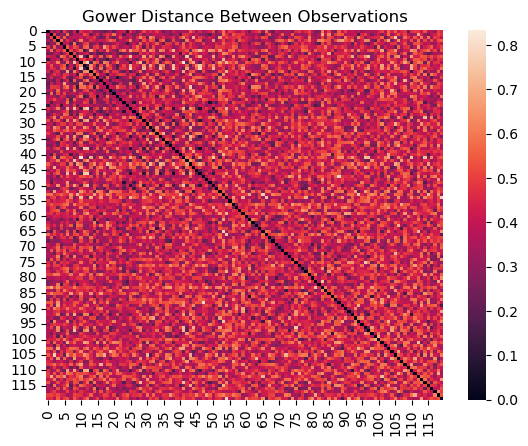

In [93]:
distance_matrix = gower.gower_matrix(df)
sns.heatmap(distance_matrix)
plt.title('Gower Distance Between Observations')
plt.show()

## Define a function to fit and plot a KMediods model
- The function takes a number of clusters and a distance matrix.
- If we don't want to plot the model, we can set `plot=False`.

In [104]:
def fit_and_plot(n_clusters,
                 df=df, 
                 distance_matrix=distance_matrix,
                 plot=True):
    # Define the model
    km_model = KMedoids(n_clusters=n_clusters, 
                        random_state=seed, 
                        metric='precomputed', 
                        method='pam', 
                        init='k-medoids++')
    # Fit the model to the distance matrix
    km_model.fit(distance_matrix)
    # Extract the cluster labels
    clusters = km_model.labels_

    # Optional plotting tool
    if plot:
        # Use the decomposition package from sklearn to generate the PCA plot 
        pca = decomposition.PCA(n_components=2)
        pca.fit(df) 
        # Plot each observation in two dimensions in a dataframe
        X = pd.DataFrame(pca.transform(df), columns=['PCA1', 'PCA2'])
        # Add clusters to the dataframe
        X['cluster'] = clusters
        
        # Plot the dataframe
        sns.scatterplot(data=X, x='PCA1', y='PCA2', hue='cluster', palette="tab10")
        plt.xlabel('PCA1 - explained variance: '+str(round(pca.explained_variance_ratio_[0],2)))
        plt.ylabel('PCA2 - explained variance: '+str(round(pca.explained_variance_ratio_[1],2)))
        plt.title(f'K-mediods Projected into Two Dimensions with {n_clusters} Clusters')
        plt.show()

    # Return the model and the data including labels
    return (km_model)

## Plot silhouette score and sum of squares

- The sum of squares is the total euclidian distance from the cluster mediod. Lower is better.
- The silhouette score balances the average distance between each point and each other point within cluster and the minimum distance from each point to another cluster. Higher is better.
- I calculated the silhouette score and the sum of squares using two through eleven clusters and ploted them in a line graph.
- There is no clear inflection point in the elbow plot. However, the silhouette plot appears to show a peak score at three clusters.
- As a result of this analysis, I will use a three-cluster solution for my k-mediods analysis 

Text(0, 0.5, 'total sum of squares')

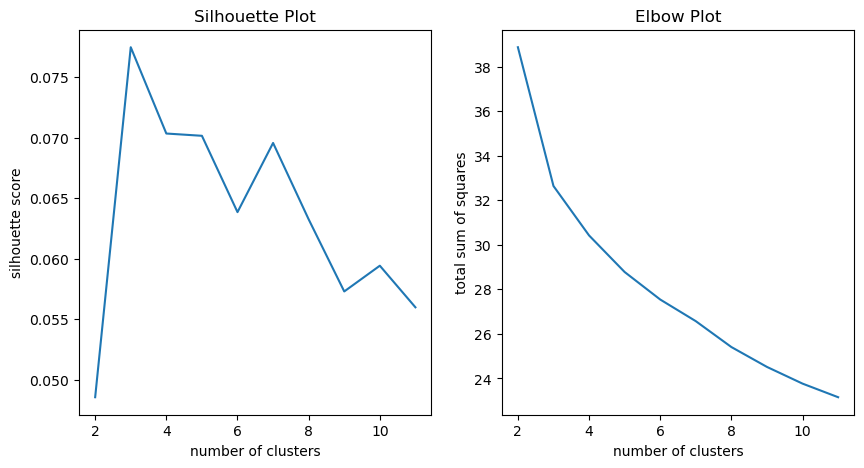

In [105]:
from sklearn.metrics import silhouette_score
tss = []
clusters = []
ss = []

for i in range(10):
    num_clusters = i+2
    km_model = fit_and_plot(num_clusters, plot=False)
    silhouette = silhouette_score(df, km_model.labels_)
    tss.append(km_model.inertia_)
    ss.append(silhouette)
    clusters.append(num_clusters)

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(x=clusters, y=ss, ax=ax[0])
ax[0].set_xlabel('number of clusters')
ax[0].set_ylabel('silhouette score')
ax[0].set_title('Silhouette Plot')

sns.lineplot(x=clusters, y=tss, ax=ax[1])
ax[1].set_title('Elbow Plot')
ax[1].set_xlabel('number of clusters')
ax[1].set_ylabel('total sum of squares')    

## Examining a three-cluster solution

- **Normalized Mutual Information** makes two splits to the data, one according to class and one according to cluster. It then tells how well the two splits agree with each other. Our data has an NMI score of 0.3141, indicating that the clusters somewhat agree with the classes.
- **Adjusted Rand Index** Similarly compares the clusters with the classes, except that the range is from -1 indicating perfect disagreement to 1 indicating perfect agreement. Our ARI of 0.2681 is positive, meaning there is some level of agreement beyond random chance, but the agreement is not very high.

I also project the data onto two PCA dimensions with the points colored according to their cluster. This figure shows some seperability of the three cluster, although there is considerable overlap.

Adjusted Rand Score: 0.2681
Normalized Mutual Info Score: 0.3141


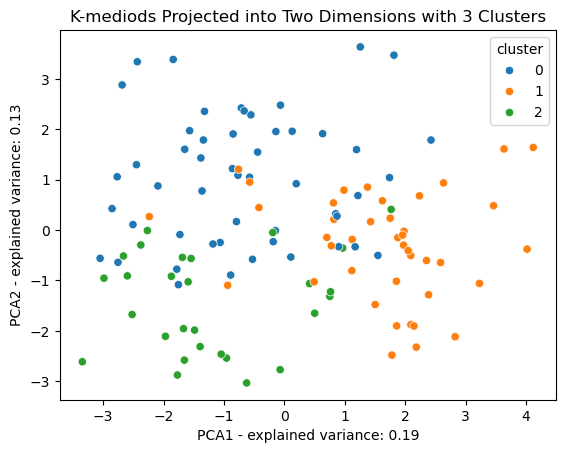

In [106]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

km_model = fit_and_plot(3, distance_matrix=distance_matrix, plot=False)

print('Adjusted Rand Score:', round(adjusted_rand_score(diagnosis, km_model.labels_),4))
print('Normalized Mutual Info Score:', round(normalized_mutual_info_score(diagnosis, km_model.labels_),4))

km_model = fit_and_plot(3, distance_matrix=distance_matrix, plot=True)

# Hierarchical Cluster Analysis

In [107]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

## Dendrograms
The following dendrogram indicates an optimal split at three clusters.

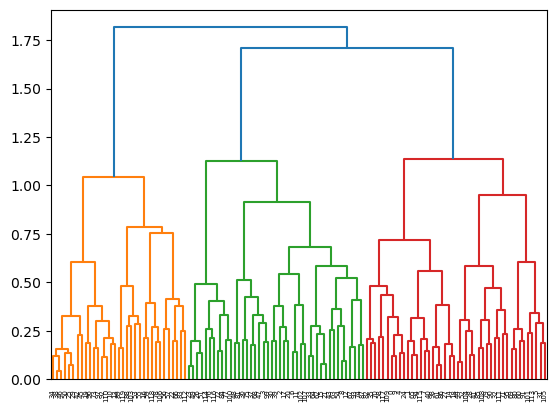

In [108]:
# scipy likes to work with a square-form distance matrix rather than a vector-form distance matrix
square_distance = squareform(distance_matrix)

linkage_data = linkage(square_distance, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

### Cluster Map
Seaborn has a nice function called cluster map which shows the values of each of the variables when clustered hierarchically. Unfortunately, this figure does not reveal any noticable clusters around variables. 

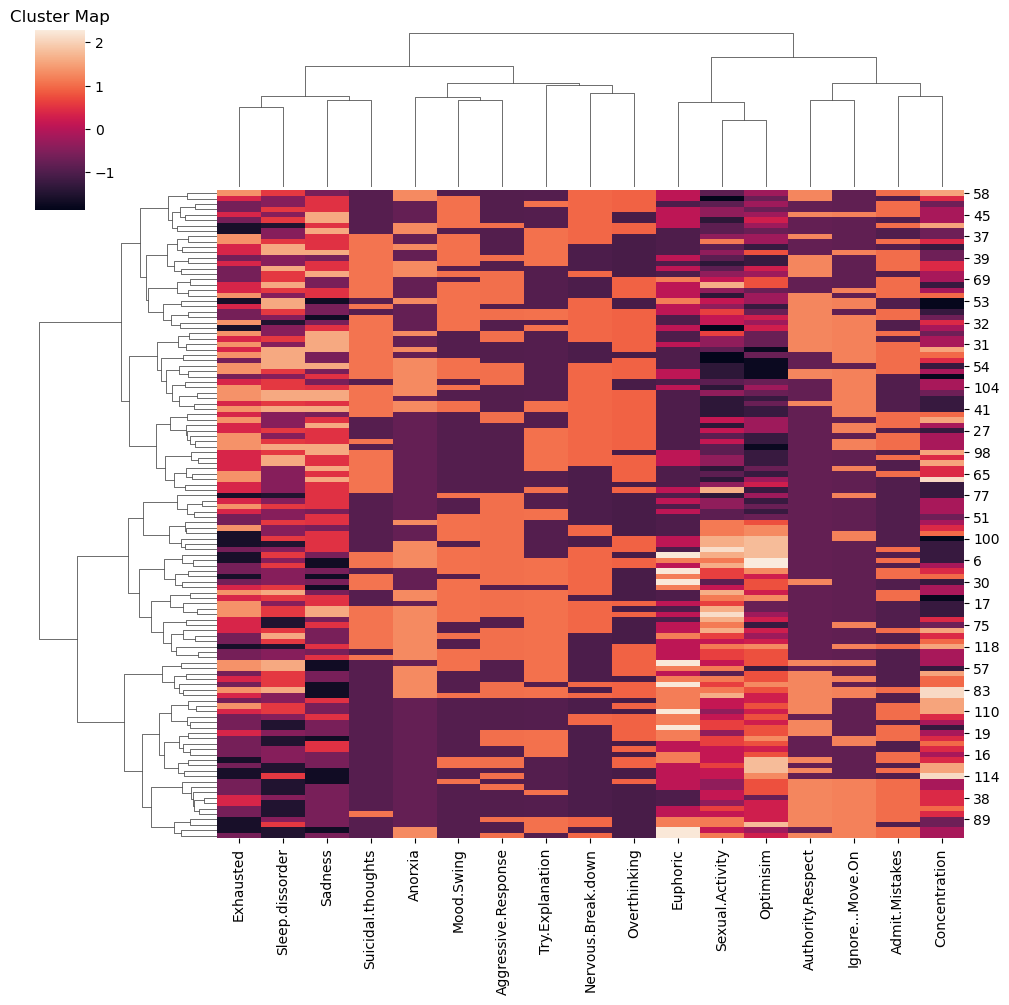

In [109]:
sns.clustermap(df,
               method='ward',)
plt.title('Cluster Map')
plt.show()

## Define a function to perform agglomerative clustering

In [110]:
from sklearn.cluster import AgglomerativeClustering

def h_fit_and_plot(n_clusters, plot=False):
    h_model = AgglomerativeClustering(n_clusters=n_clusters, 
                                        metric='euclidean', 
                                        memory=None, 
                                        connectivity=None, 
                                        compute_full_tree='auto', 
                                        linkage='ward', 
                                        distance_threshold=None, 
                                        compute_distances=False).fit(df)
    clusters = h_model.labels_
    pca = decomposition.PCA(n_components=2)
    pca.fit(df) 
    if plot:
        X = pd.DataFrame(pca.transform(df), columns=['PCA1', 'PCA2'])
        X['cluster'] = clusters
        sns.scatterplot(data=X, x='PCA1', y='PCA2', hue='cluster', palette="tab10")
        plt.xlabel('PCA1 - explained variance: '+str(round(pca.explained_variance_ratio_[0],2)))
        plt.ylabel('PCA2 - explained variance: '+str(round(pca.explained_variance_ratio_[1],2)))
        plt.title(f'Hierarchical Clusters Projected into Two Dimensions with {n_clusters} Clusters')
    return h_model

## Examine the clusters
As seen in the chunk below, hierarchical modeling returns better information scores according to the ARS as well as the NMI score. As a result, and due to the superior interpretability of the hierarchical method, this appears to be the better clustering method.
The clusters projected into two PCA dimensions look similar to what I saw with k-medioids, although they seem to be a bit more seperable.

Adjusted Rand Score: 0.3913
Normalized Mutual Info Score: 0.4437


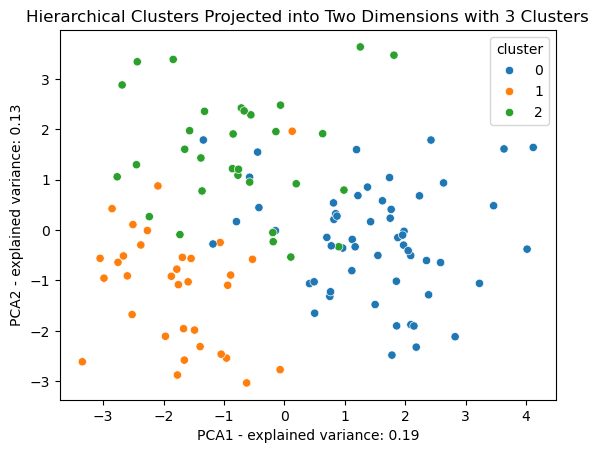

In [111]:
h_model = h_fit_and_plot(3, plot=False)

print('Adjusted Rand Score:', round(adjusted_rand_score(diagnosis, h_model.labels_),4))
print('Normalized Mutual Info Score:', round(normalized_mutual_info_score(diagnosis, h_model.labels_),4))

h_model = h_fit_and_plot(3, plot=True)

# Conclusion
In this notebook I attempted two different unsupervised machine learning techniques to attempt to discern natural clusters in the data on bipolar depression - k-mediods and agglomerative hierarchical clustering. Using silhouette scores for k-medioids and a visual inspection of the dendrogram from hierarchical clustering, I settled on a three-cluster solution for each. The clusters uncovered by both methods mapped onto the expert diagnosis better than random chance, although the hierarchical clustering method mapped more closely onto the expert diagnosis.